#### 2. Анализ риск-факторов

##### Установка пакетов, загрузка и предобработка данных

In [89]:
pip install pymannkendall

Note: you may need to restart the kernel to use updated packages.


In [103]:
import pandas as pd
import numpy as np
np.warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import scipy.stats as scs
import statsmodels.tsa.stattools as stat
import statsmodels.graphics.tsaplots as spl
import statsmodels.graphics.gofplots
import statsmodels.tsa.seasonal as season

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import pymannkendall as mk
from statsmodels.tsa.stattools import adfuller


import matplotlib as mpl
%matplotlib inline

Загрузим данные по риск-факторам. Для анализа будем использовать информацию о закрытии.

In [306]:
url_zero = 'https://raw.githubusercontent.com/Penitto/risk_project1/master/zerobond.csv?token=ANGTEFTYY72T4L37HSJFT7K6LAG3E'
df_zero = pd.read_csv(url_zero, sep = ';')
df_zero['Date'] = pd.to_datetime(df_zero['Date'])

In [307]:
url_rts = 'https://raw.githubusercontent.com/Penitto/risk_project1/master/index/RTSI_160101_200101.csv?token=ANGTEFSOHJZLYH6333D63WC6LAHBQ'
df_rts = pd.read_csv(url_rts)
df_rts = df_rts.drop(['<TICKER>', '<PER>', '<TIME>', '<OPEN>', '<HIGH>', '<LOW>', '<VOL>'], axis = 1)
df_rts['<DATE>'] = pd.to_datetime(df_rts['<DATE>'])
rts = df_rts['<CLOSE>']
rts_date = df_rts['<DATE>']

In [308]:
url_moex = 'https://raw.githubusercontent.com/Penitto/risk_project1/master/index/IMOEX_160101_200101.csv?token=ANGTEFRL66HHHUBN7CKLFOC6LAHFC'
df_moex = pd.read_csv(url_moex)
df_moex = df_moex.drop(['<TICKER>', '<PER>', '<TIME>', '<OPEN>', '<HIGH>', '<LOW>', '<VOL>'], axis = 1)
df_moex['<DATE>'] = pd.to_datetime(df_moex['<DATE>'])
moex = df_moex['<CLOSE>']
moex_date = df_moex['<DATE>']

In [309]:
url_usd = 'https://raw.githubusercontent.com/Penitto/risk_project1/master/index/USD_RUB.csv?token=ANGTEFV2OHDJLVEU54IKCA26LAHOA'
df_usd = pd.read_csv(url_usd)
df_usd = df_usd.drop(['Open', 'High', 'Low', 'Change %'], axis = 1)
df_usd['Date'] = pd.to_datetime(df_usd['Date'])
usd = df_usd['Price']
usd_date = df_usd['Date']

In [310]:
url_cyn = 'https://raw.githubusercontent.com/Penitto/risk_project1/master/index/CNY_RUB.csv?token=ANGTEFUAX6XQWTH5DAA35XC6LAHSO'
df_cyn = pd.read_csv(url_cyn)
df_cyn = df_cyn.drop(['Open', 'High', 'Low', 'Change %'], axis = 1)
df_cyn['Date'] = pd.to_datetime(df_cyn['Date'])
cyn = df_cyn['Price']
cyn_date = df_cyn['Date']

In [311]:
url_oil = 'https://raw.githubusercontent.com/Penitto/risk_project1/master/index/ICE.BRN_160101_200101.csv?token=ANGTEFUEDHB4KGIJRVTWJEC6LAHWY'
df_oil = pd.read_csv(url_oil)
df_oil = df_oil.drop(['<TICKER>', '<PER>', '<TIME>', '<OPEN>', '<HIGH>', '<LOW>', '<VOL>'], axis = 1)
df_oil['<DATE>'] = pd.to_datetime(df_oil['<DATE>'])
oil = df_oil['<CLOSE>']
oil_date = df_oil['<DATE>']

Так как данные немного отличаются по временной структуре, то приведем их к одному виду.
Сначала будем проводить анализ на исходных данных.

In [312]:
risk_factors = {'Date': df_rts['<DATE>'],
                'RTS': df_rts['<CLOSE>'],
                'MOEX': df_moex['<CLOSE>'],
                'USD': df_usd['Price'],
                'CYN': df_cyn['Price'],
                'OIL': df_oil['<CLOSE>']}

df_risk = pd.DataFrame(risk_factors, columns = ['Date', 'RTS', 'MOEX', 'USD', 'CYN', 'OIL'])

df_risk = df_risk.dropna()
df_risk = df_risk.reset_index(drop=True)

In [313]:
df = pd.merge(df_risk,df_zero, on = 'Date',  how = 'inner')

In [314]:
df.describe()

,RTS,MOEX,USD,CYN,OIL,3,6,9,12,24,36,60,84,120,180,240,360
count,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000
mean,1123.414318,2245.365851,63.225625,9.429998,57.874209,7.861910,7.860796,7.855194,7.850766,7.856488,7.883453,7.939483,7.994577,8.083940,8.235612,8.372249,8.593960
std,165.647046,316.472493,4.609221,0.796721,12.275552,1.280293,1.238450,1.199312,1.161741,1.046552,0.984022,0.905489,0.846261,0.770762,0.674787,0.613108,0.600201
min,628.410000,1608.360000,55.713400,8.109400,27.790000,4.980000,5.090000,5.210000,5.320000,5.650000,5.800000,6.050000,6.270000,6.480000,6.590000,6.640000,6.680000
25%,1018.180000,1976.370000,59.299800,8.834200,49.130000,6.820000,6.860000,6.890000,6.940000,7.070000,7.180000,7.320000,7.420000,7.590000,7.870000,8.100000,8.370000
50%,1134.070000,2226.360000,63.762800,9.450900,55.710000,7.540000,7.550000,7.600000,7.630000,7.850000,7.940000,7.960000,7.980000,8.050000,8.170000,8.350000,8.680000
75%,1219.780000,2445.550000,65.632800,9.796700,67.300000,9.130000,9.150000,9.020000,8.880000,8.500000,8.380000,8.530000,8.550000,8.570000,8.640000,8.690000,8.910000
max,1549.400000,3050.470000,82.681300,12.605600,86.100000,10.500000,10.330000,10.620000,10.740000,10.760000,10.850000,10.930000,10.940000,10.900000,10.870000,10.850000,10.850000


Описательная статистика риск-факторов: 
- основные статистические характеристки;
- «тяжесть хвостов» распределений;
- тренд, сезонность, стационарность.


In [315]:
rts = df['RTS']
moex = df['MOEX']
usd = df['USD']
cyn = df['CYN']
oil = df['OIL']
m3 = df['3']
m6 = df['6']
m9 = df['9']
y1 = df['12']
y2 = df['24']
y3 = df['36']
y5 = df['60']
y7 = df['84']
y10 = df['120']
y15 = df['180']
y20 = df['240']
y30 = df['360']

In [316]:
def desc_risk(y, figsize=(15, 10), style='bmh' ):
    with plt.style.context(style):    
        print(y.describe())
        
        print(mk.original_test(y))
        #If the pvalue is above a critical size, then we cannot reject that there is a unit root.
        
        #adf with constant
        adf_c = adfuller(y, regression = 'c')
        print('ADF Statistic const: %f' % adf_c[0])
        print('p-value: %f' % adf_c[1])
        
        #adf with constant and trend
        adf_ct = adfuller(y, regression = 'ct')
        print('ADF Statistic trend: %f' % adf_ct[0])
        print('p-value: %f' % adf_ct[1])
        
        #adf with no constant and no trend
        adf_nc = adfuller(y, regression = 'nc')
        print('ADF Statistic trend: %f' % adf_nc[0])
        print('p-value: %f' % adf_nc[1])
        
        
        fig = plt.figure(figsize=figsize)
        layout = (4, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        prob_ax = plt.subplot2grid(layout, (3, 0))
        hist_ax = plt.subplot2grid(layout, (3, 1))

        y.plot(figsize=(15, 10), ax = ts_ax)
        spl.plot_acf(y, lags = 30, ax = acf_ax)
        spl.plot_pacf(y, lags = 30, ax = pacf_ax)
        
        #normal distribution
        pp_n = statsmodels.graphics.gofplots.ProbPlot(y, fit=True)
        pp_n.qqplot(line ='r', ax = qq_ax); plt.title('Q-Q')
        pp_n.ppplot(line='45', ax = pp_ax); plt.title('P-P')
        pp_n.probplot(line='r', ax = prob_ax); plt.title('Prob')
        
        y.hist(bins = 30, ax = hist_ax); 
        plt.title('Histogram')
    return

count    1005.000000
mean     1123.414318
std       165.647046
min       628.410000
25%      1018.180000
50%      1134.070000
75%      1219.780000
max      1549.400000
Name: RTS, dtype: float64
Mann_Kendall_Test(trend='increasing', h=True, p=0.0, z=33.11642213459962, Tau=0.697631365086916, s=351962.0, var_s=112954169.33333333, slope=0.48808686892020214)
ADF Statistic const: -1.201801
p-value: 0.672820
ADF Statistic trend: -2.735448
p-value: 0.221661
ADF Statistic trend: 1.442114
p-value: 0.962667


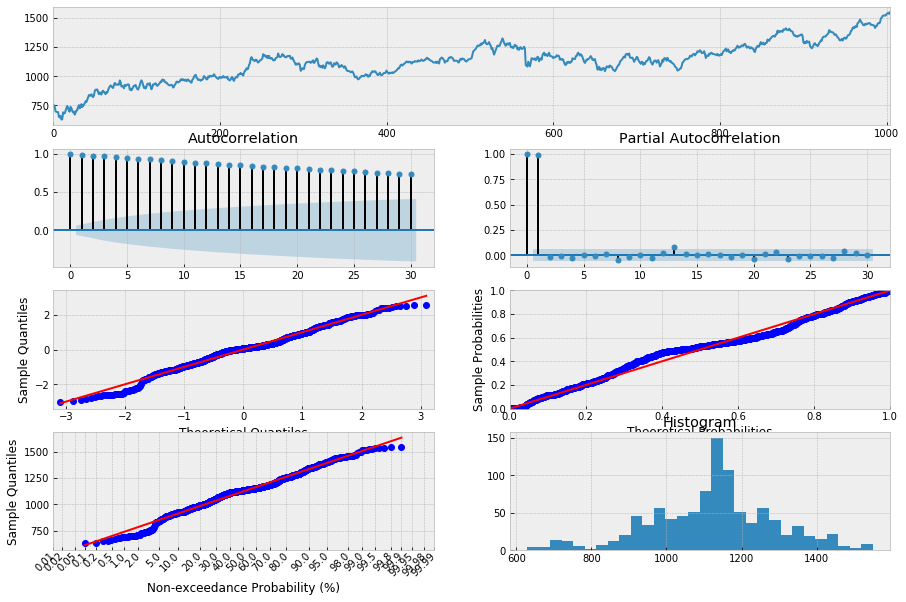

In [317]:
desc_risk(rts)

count    1005.000000
mean     2245.365851
std       316.472493
min      1608.360000
25%      1976.370000
50%      2226.360000
75%      2445.550000
max      3050.470000
Name: MOEX, dtype: float64
Mann_Kendall_Test(trend='increasing', h=True, p=0.0, z=38.59055075185728, Tau=0.8129491982319478, s=410141.0, var_s=112954178.33333333, slope=1.0175695696216809)
ADF Statistic const: -0.053745
p-value: 0.953855
ADF Statistic trend: -2.169865
p-value: 0.506821
ADF Statistic trend: 2.040018
p-value: 0.991290


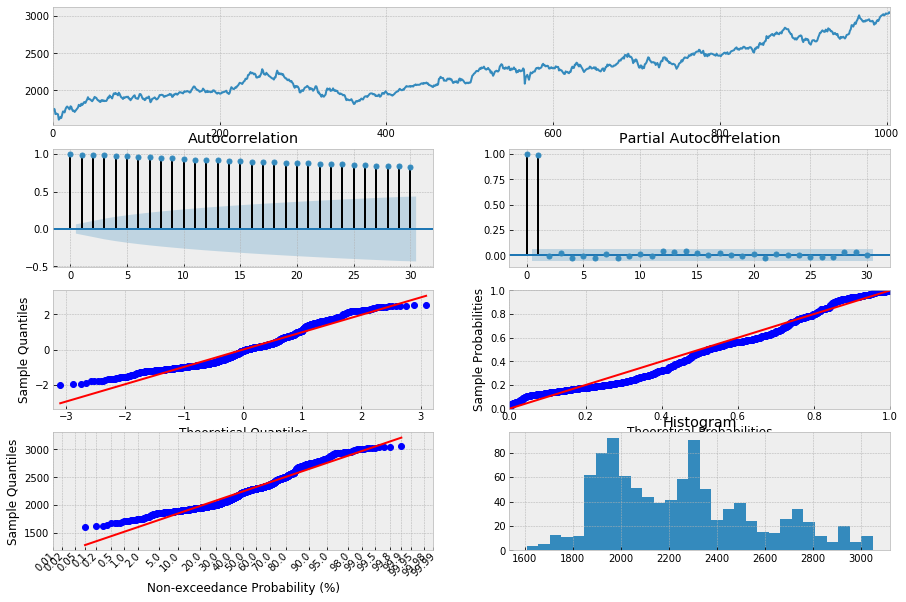

In [318]:
desc_risk(moex)

count    1005.000000
mean       63.225625
std         4.609221
min        55.713400
25%        59.299800
50%        63.762800
75%        65.632800
max        82.681300
Name: USD, dtype: float64
Mann_Kendall_Test(trend='no trend', h=False, p=0.9616520184764967, z=0.04808058594989539, Tau=0.0010148460882836812, s=512.0, var_s=112954177.33333333, slope=2.0214164273563658e-05)
ADF Statistic const: -3.567221
p-value: 0.006420
ADF Statistic trend: -3.638325
p-value: 0.026754
ADF Statistic trend: -1.189982
p-value: 0.214022


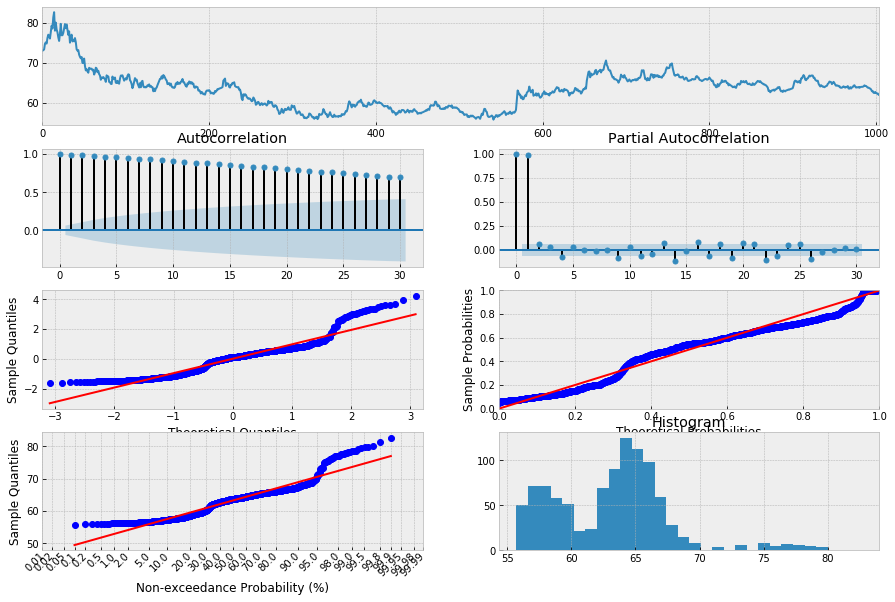

In [319]:
desc_risk(usd)

Text(0.5, 1.0, 'Prob')

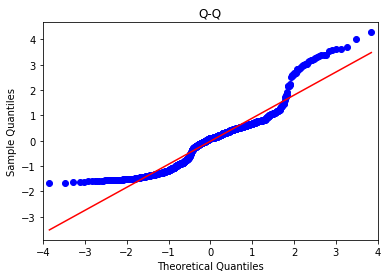

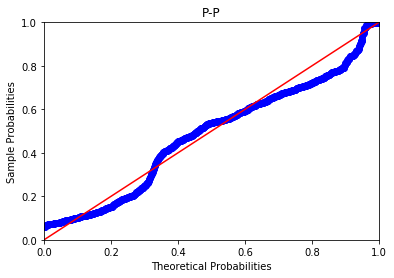

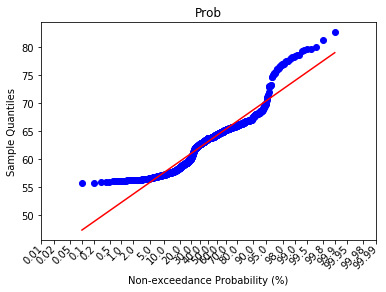

In [320]:
#student distir
y = usd        
pp_n = statsmodels.graphics.gofplots.ProbPlot(y, dist=scs.t, fit=True)
pp_n.qqplot(line ='r'); plt.title('Q-Q')
pp_n.ppplot(line='45'); plt.title('P-P')
pp_n.probplot(line='r'); plt.title('Prob')

count    1005.000000
mean        9.429998
std         0.796721
min         8.109400
25%         8.834200
50%         9.450900
75%         9.796700
max        12.605600
Name: CYN, dtype: float64
Mann_Kendall_Test(trend='no trend', h=False, p=0.1991201189496432, z=-1.2840624109640275, Tau=-0.027051991040811876, s=-13648.0, var_s=112954130.66666667, slope=-0.00011831523492097709)
ADF Statistic const: -3.670365
p-value: 0.004550
ADF Statistic trend: -3.363267
p-value: 0.056493
ADF Statistic trend: -1.365006
p-value: 0.159952


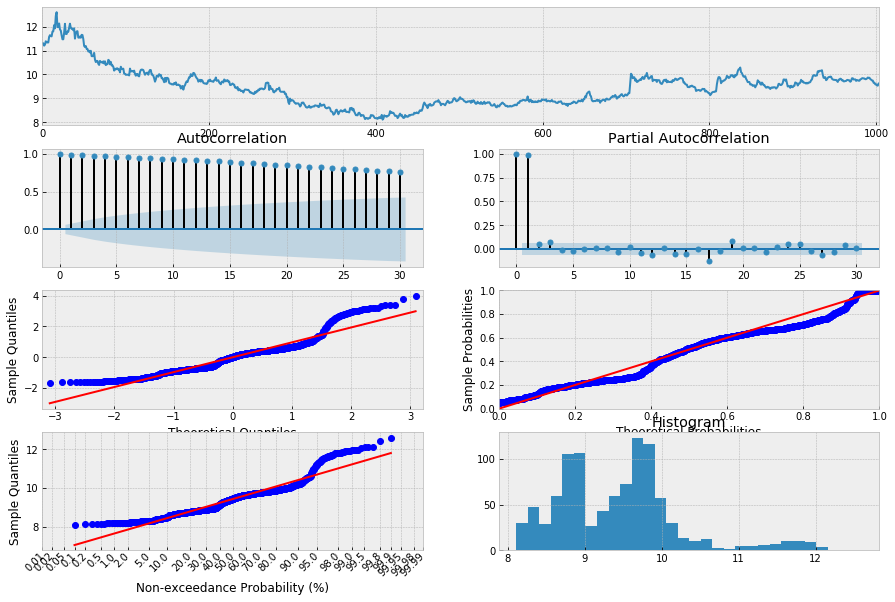

In [321]:
desc_risk(cyn)

Text(0.5, 1.0, 'Prob')

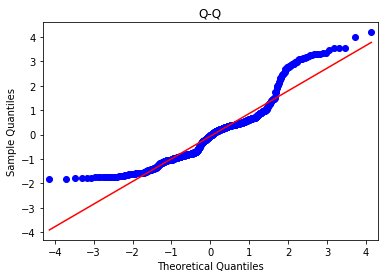

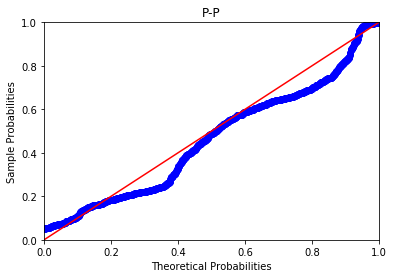

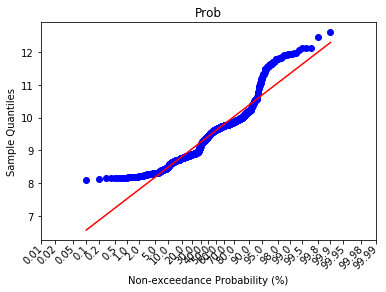

In [322]:
#student distir
y = cyn    
pp_n = statsmodels.graphics.gofplots.ProbPlot(y, dist=scs.t, fit=True)
pp_n.qqplot(line ='r'); plt.title('Q-Q')
pp_n.ppplot(line='45'); plt.title('P-P')
pp_n.probplot(line='r'); plt.title('Prob')

count    1005.000000
mean       57.874209
std        12.275552
min        27.790000
25%        49.130000
50%        55.710000
75%        67.300000
max        86.100000
Name: OIL, dtype: float64
Mann_Kendall_Test(trend='increasing', h=True, p=0.0, z=31.64805140615817, Tau=0.6666983806069255, s=336356.0, var_s=112954054.66666667, slope=0.03869395370088335)
ADF Statistic const: -1.553689
p-value: 0.506805
ADF Statistic trend: -2.184812
p-value: 0.498402
ADF Statistic trend: 0.784791
p-value: 0.882347


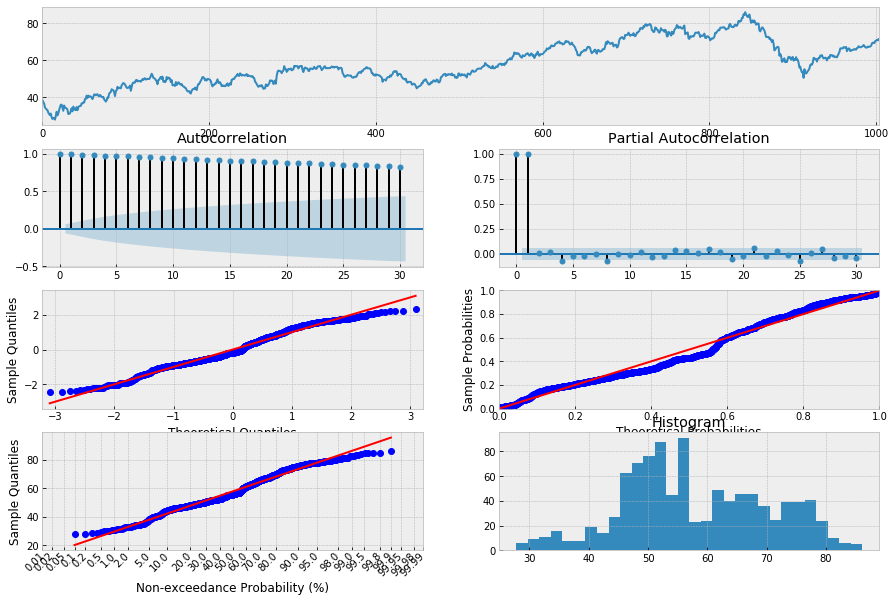

In [323]:
desc_risk(oil)

count    1005.000000
mean        7.861910
std         1.280293
min         4.980000
25%         6.820000
50%         7.540000
75%         9.130000
max        10.500000
Name: 3, dtype: float64
Mann_Kendall_Test(trend='decreasing', h=True, p=0.0, z=-29.334191851796323, Tau=-0.6179481080652515, s=-311761.0, var_s=112951637.0, slope=-0.0037903225806451644)
ADF Statistic const: -0.005548
p-value: 0.958071
ADF Statistic trend: -2.141742
p-value: 0.522657
ADF Statistic trend: -1.298684
p-value: 0.179230


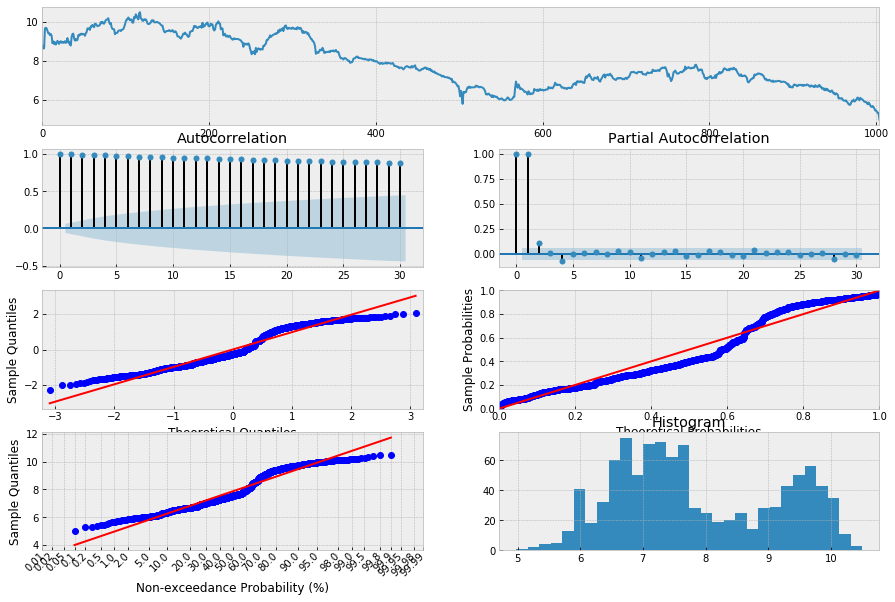

In [324]:
desc_risk(df['3'])

count    1005.000000
mean        7.860796
std         1.238450
min         5.090000
25%         6.860000
50%         7.550000
75%         9.150000
max        10.330000
Name: 6, dtype: float64
Mann_Kendall_Test(trend='decreasing', h=True, p=0.0, z=-31.22142657223258, Tau=-0.6577015321797387, s=-331817.0, var_s=112950761.0, slope=-0.0037500000000000016)
ADF Statistic const: -0.676596
p-value: 0.852719
ADF Statistic trend: -1.760439
p-value: 0.723515
ADF Statistic trend: -2.267722
p-value: 0.022456


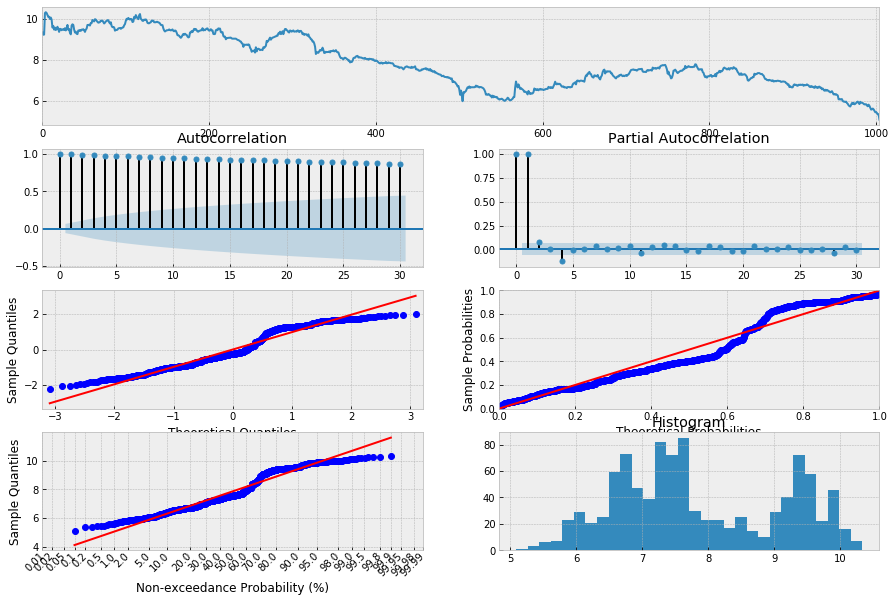

In [325]:
desc_risk(df['6'])

count    1005.000000
mean        7.855194
std         1.199312
min         5.210000
25%         6.890000
50%         7.600000
75%         9.020000
max        10.620000
Name: 9, dtype: float64
Mann_Kendall_Test(trend='decreasing', h=True, p=0.0, z=-32.01229688877022, Tau=-0.67436324354324, s=-340223.0, var_s=112951269.0, slope=-0.003673469387755105)
ADF Statistic const: -0.253815
p-value: 0.931796
ADF Statistic trend: -1.875870
p-value: 0.667079
ADF Statistic trend: -2.032439
p-value: 0.040308


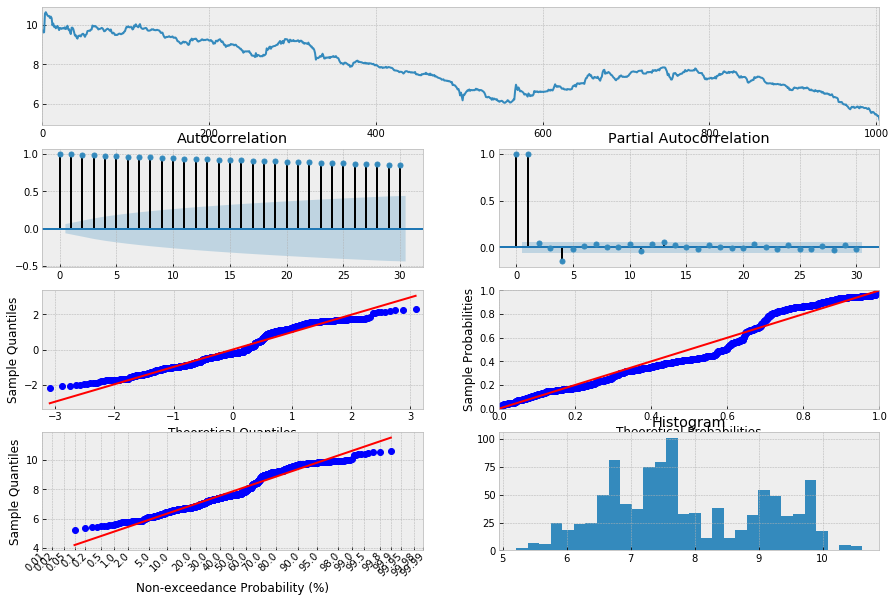

In [326]:
desc_risk(df['9'])

count    1005.000000
mean        7.850766
std         1.161741
min         5.320000
25%         6.940000
50%         7.630000
75%         8.880000
max        10.740000
Name: 12, dtype: float64
Mann_Kendall_Test(trend='decreasing', h=True, p=0.0, z=-32.30833238943763, Tau=-0.6805989970466393, s=-343369.0, var_s=112951123.0, slope=-0.0035952222433580628)
ADF Statistic const: -0.376048
p-value: 0.914022
ADF Statistic trend: -1.508822
p-value: 0.826093
ADF Statistic trend: -2.357261
p-value: 0.017740


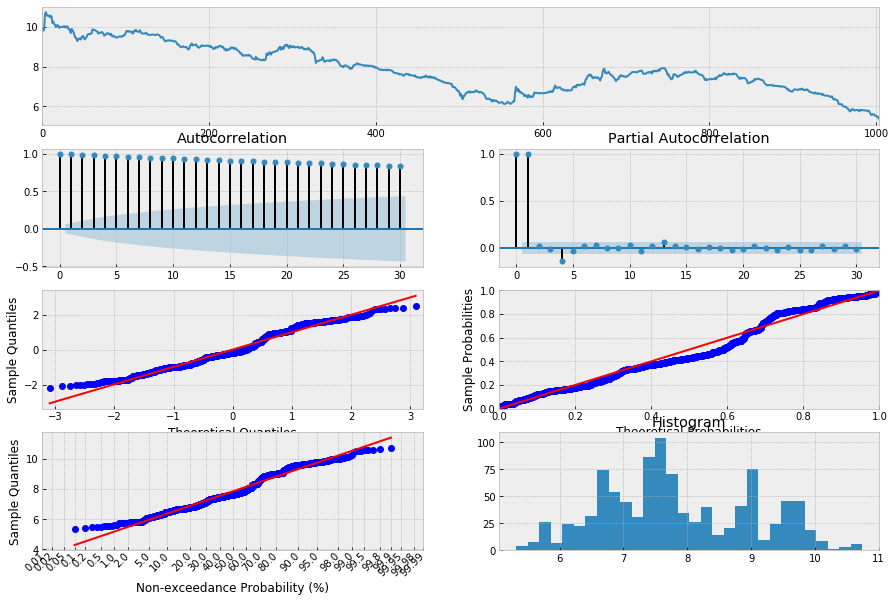

In [327]:
desc_risk(df['12'])

count    1005.000000
mean        7.856488
std         1.046552
min         5.650000
25%         7.070000
50%         7.850000
75%         8.500000
max        10.760000
Name: 24, dtype: float64
Mann_Kendall_Test(trend='decreasing', h=True, p=0.0, z=-31.82289739384929, Tau=-0.6703712513131553, s=-338209.0, var_s=112950541.0, slope=-0.003333333333333328)
ADF Statistic const: -0.880568
p-value: 0.794304
ADF Statistic trend: -1.572562
p-value: 0.802993
ADF Statistic trend: -2.326733
p-value: 0.019240


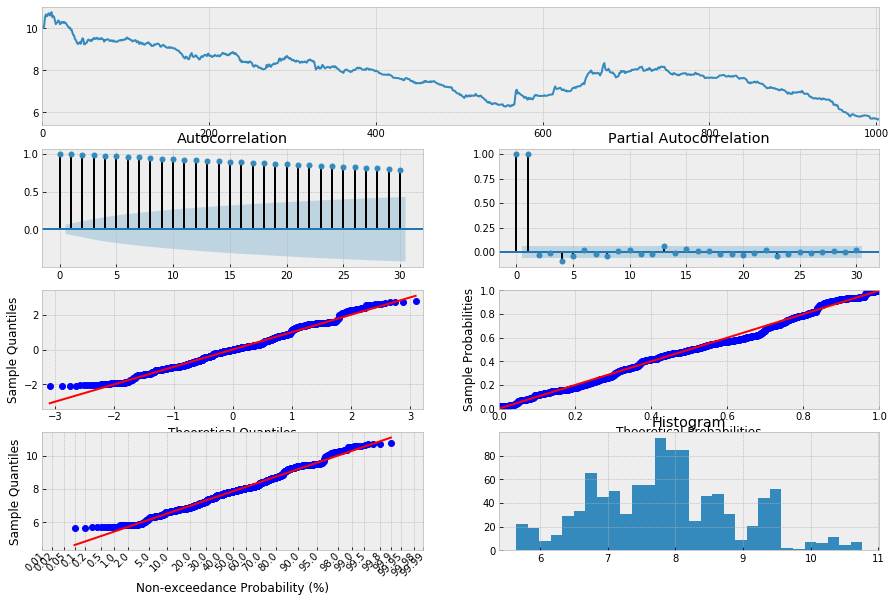

In [328]:
desc_risk(df['24'])

count    1005.000000
mean        7.883453
std         0.984022
min         5.800000
25%         7.180000
50%         7.940000
75%         8.380000
max        10.850000
Name: 36, dtype: float64
Mann_Kendall_Test(trend='decreasing', h=True, p=0.0, z=-29.437221560054162, Tau=-0.6201145666091852, s=-312854.0, var_s=112950202.66666667, slope=-0.003069767441860466)
ADF Statistic const: -1.097216
p-value: 0.716181
ADF Statistic trend: -1.649887
p-value: 0.772293
ADF Statistic trend: -2.074787
p-value: 0.036416


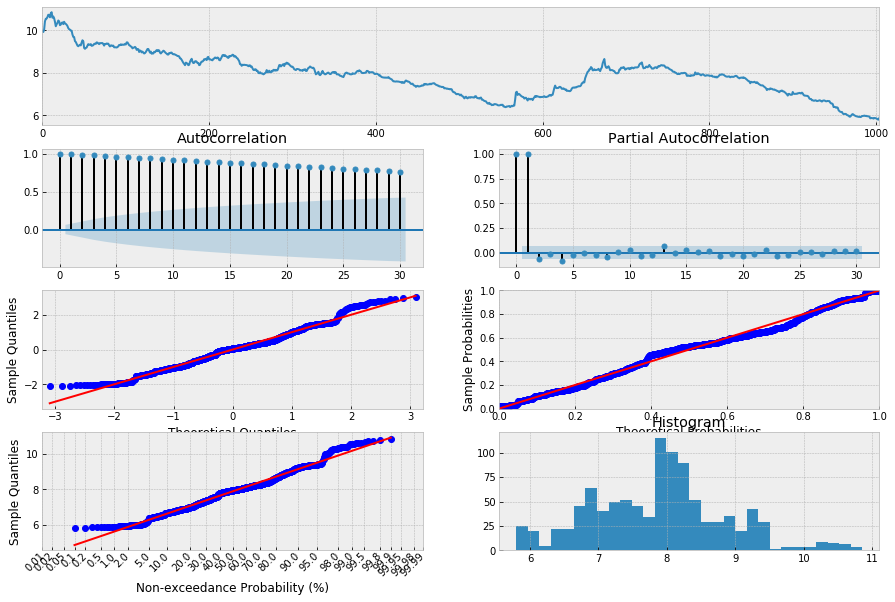

In [329]:
desc_risk(df['36'])

count    1005.000000
mean        7.939483
std         0.905489
min         6.050000
25%         7.320000
50%         7.960000
75%         8.530000
max        10.930000
Name: 60, dtype: float64
Mann_Kendall_Test(trend='decreasing', h=True, p=0.0, z=-25.356623522941312, Tau=-0.5341539315375314, s=-269486.0, var_s=112950029.33333333, slope=-0.002586104634515478)
ADF Statistic const: -1.298668
p-value: 0.629781
ADF Statistic trend: -1.742149
p-value: 0.731963
ADF Statistic trend: -1.690849
p-value: 0.086028


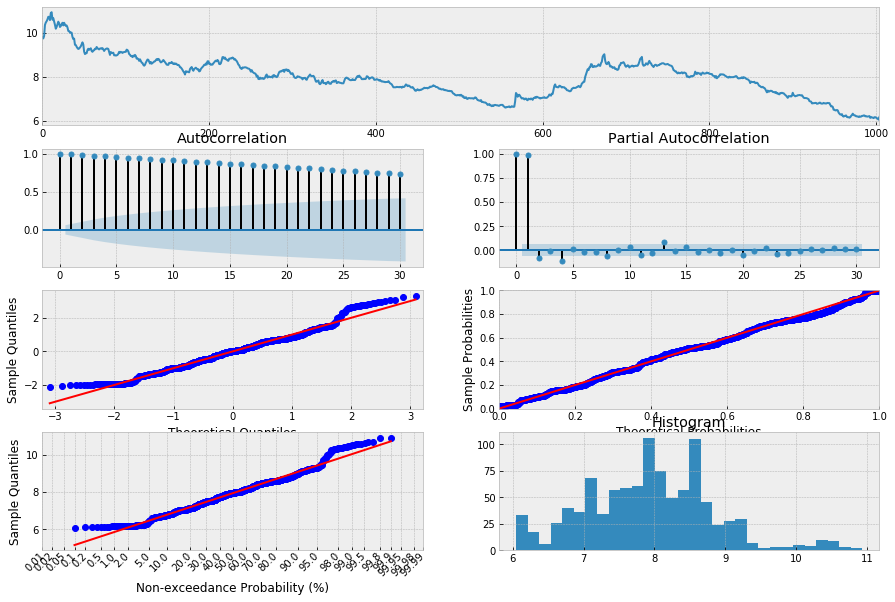

In [330]:
desc_risk(df['60'])

count    1005.000000
mean        7.994577
std         0.846261
min         6.270000
25%         7.420000
50%         7.980000
75%         8.550000
max        10.940000
Name: 84, dtype: float64
Mann_Kendall_Test(trend='decreasing', h=True, p=0.0, z=-22.913578043125526, Tau=-0.4826901349824582, s=-243522.0, var_s=112950202.66666667, slope=-0.002243125904486252)
ADF Statistic const: -2.090947
p-value: 0.248171
ADF Statistic trend: -2.189978
p-value: 0.495493
ADF Statistic trend: -2.110978
p-value: 0.033345


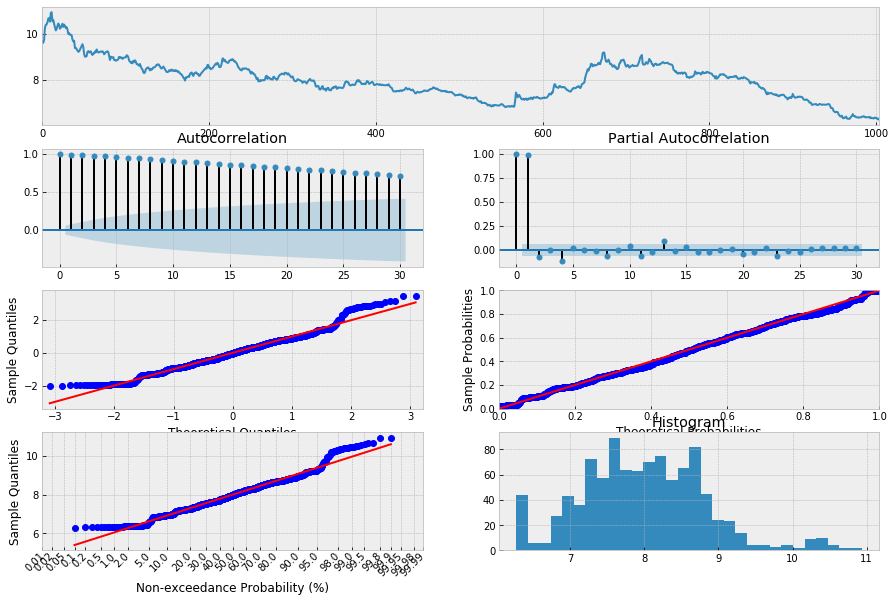

In [331]:
desc_risk(df['84'])

count    1005.000000
mean        8.083940
std         0.770762
min         6.480000
25%         7.590000
50%         8.050000
75%         8.570000
max        10.900000
Name: 120, dtype: float64
Mann_Kendall_Test(trend='decreasing', h=True, p=0.0, z=-20.800671546343796, Tau=-0.438177637707875, s=-221065.0, var_s=112948725.66666667, slope=-0.0018612829918361795)
ADF Statistic const: -2.005657
p-value: 0.284098
ADF Statistic trend: -2.127324
p-value: 0.530766
ADF Statistic trend: -1.971650
p-value: 0.046500


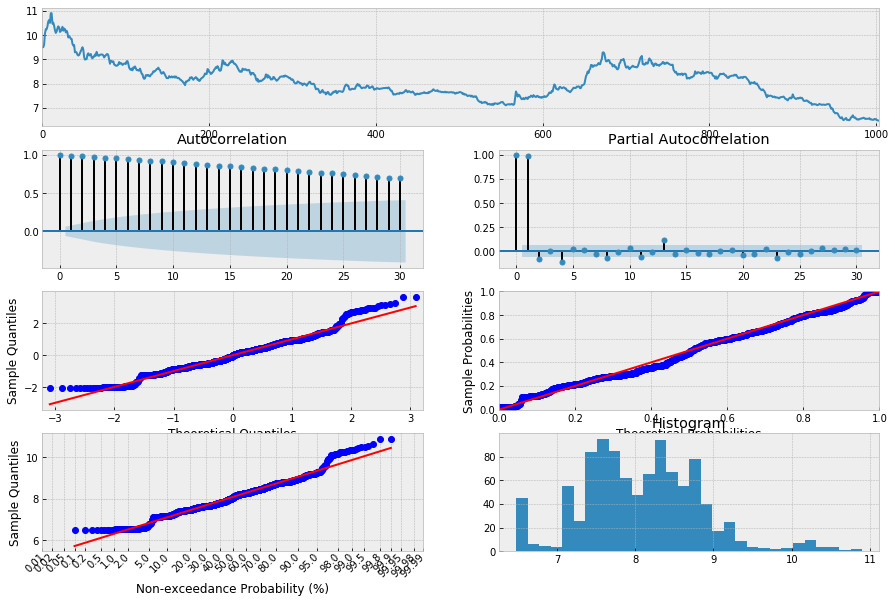

In [332]:
desc_risk(df['120'])

count    1005.000000
mean        8.235612
std         0.674787
min         6.590000
25%         7.870000
50%         8.170000
75%         8.640000
max        10.870000
Name: 180, dtype: float64
Mann_Kendall_Test(trend='decreasing', h=True, p=0.0, z=-20.063147868824476, Tau=-0.4226378069810311, s=-213225.0, var_s=112946824.33333333, slope=-0.001375754832752147)
ADF Statistic const: -1.869331
p-value: 0.346623
ADF Statistic trend: -2.132265
p-value: 0.527988
ADF Statistic trend: -1.842768
p-value: 0.062241


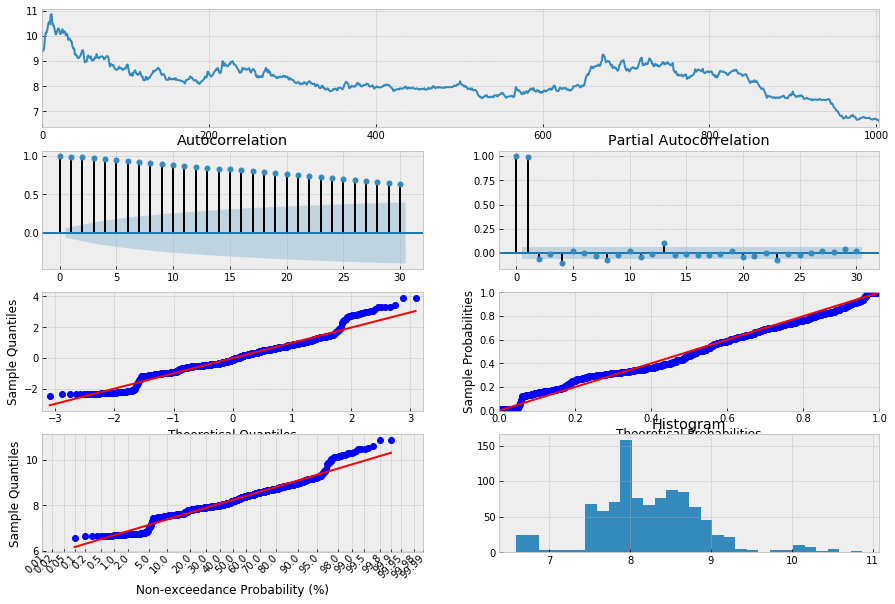

In [333]:
desc_risk(df['180'])

count    1005.000000
mean        8.372249
std         0.613108
min         6.640000
25%         8.100000
50%         8.350000
75%         8.690000
max        10.850000
Name: 240, dtype: float64
Mann_Kendall_Test(trend='decreasing', h=True, p=0.0, z=-19.446596452156296, Tau=-0.40964500208122734, s=-206670.0, var_s=112944080.0, slope=-0.0011428571428571414)
ADF Statistic const: -1.814491
p-value: 0.373291
ADF Statistic trend: -2.276526
p-value: 0.446975
ADF Statistic trend: -1.696039
p-value: 0.085113


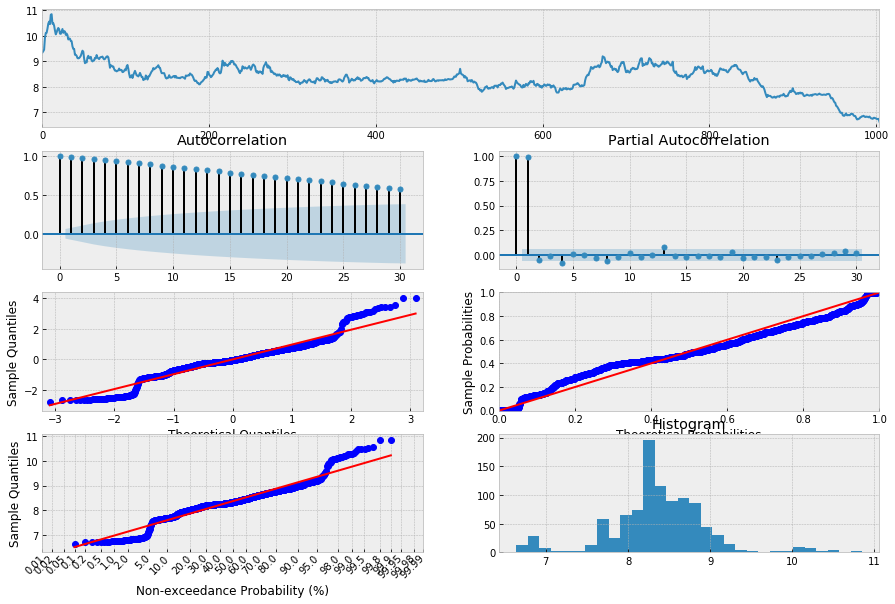

In [334]:
desc_risk(df['240'])

count    1005.000000
mean        8.593960
std         0.600201
min         6.680000
25%         8.370000
50%         8.680000
75%         8.910000
max        10.850000
Name: 360, dtype: float64
Mann_Kendall_Test(trend='decreasing', h=True, p=0.0, z=-17.633207115939683, Tau=-0.3714435789181582, s=-187397.0, var_s=112942661.0, slope=-0.0009821428571428574)
ADF Statistic const: -1.289659
p-value: 0.633890
ADF Statistic trend: -2.213867
p-value: 0.482050
ADF Statistic trend: -1.103594
p-value: 0.244453


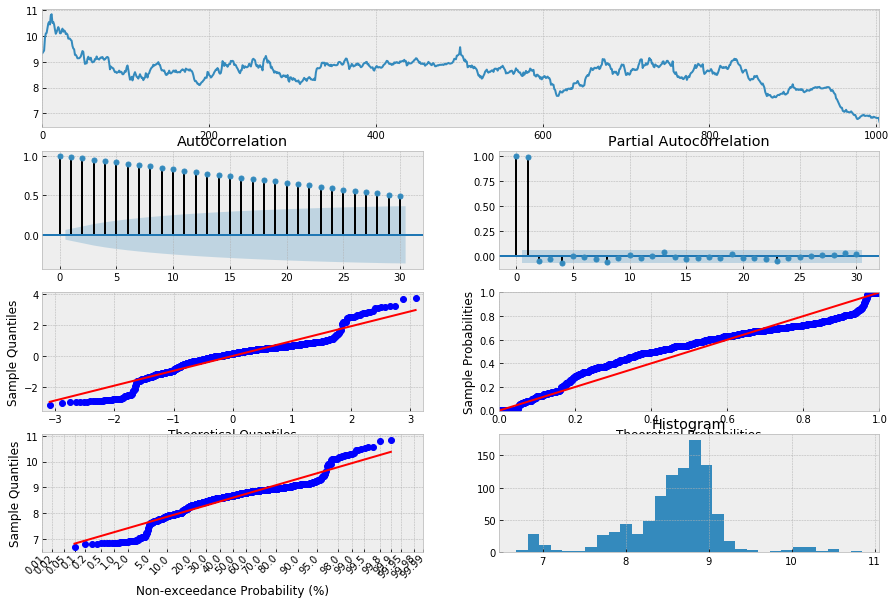

In [335]:
desc_risk(df['360'])

#### Основные вывод по описательной статистике: 
- индекс РТС в среднем имел значение на момент закрытия торгов в 1123 рубля. При этом в данных имеется восходящий тренд, при этом не является стационарным по тесту Дики-Фулера. Распределение не имеет тяжелых хвостов и похоже на нормальное.
- индекс МосБиржи на протяжении изучаемого периода имел в среднем цену закрытия в 2245 рублей. В данном ряде также имеется восходящий тренд, а сам ряд не является стационарным. В распределении выделяются левый и правый хвосты. Основное количество значений смещено к левому хвосту.
- значение курса доллара к рублю за период в среднем было равно 63 рубля за доллар. В данных не прослеживается тренд, но и ряд является стационарным. Распределение не является нормальным или близким к нему. Не совпадает оно также и с распределением Стьюдента.
- значение курса юаня к рублю за период в среднем было равно 9.4 рубля за юань. Тест на тренд отклоняется, в данных нет тренда. При этом значения являются стационарными на уровне 5%. Само распределение имеет выделяющиеся хвосты и не похоже ни на нормальное, ни на Стьюдента. 
- значением нефти марки Брент за период было равно 57.8 рублям за баррель. В данных есть восходящий тренд. Тесты на стационарность отвергаются, ряд не стационарный. Распределение близко к нормальному, но имеет тяжелые хвосты. 
- значение ставок на разный срок имеют нисходящий тренд.

#### Взаимодействие факторов

In [336]:
df.corr()

,RTS,MOEX,USD,CYN,OIL,3,6,9,12,24,36,60,84,120,180,240,360
RTS,1.000000,0.900234,-0.413199,-0.392874,0.666406,-0.771157,-0.823423,-0.853464,-0.872594,-0.902809,-0.901011,-0.871435,-0.837820,-0.803139,-0.792814,-0.800192,-0.743306
MOEX,0.900234,1.000000,0.006270,-0.060300,0.734999,-0.750900,-0.773464,-0.782223,-0.784576,-0.766542,-0.731161,-0.661248,-0.609211,-0.568871,-0.582132,-0.640066,-0.720099
USD,-0.413199,0.006270,1.000000,0.838004,-0.061353,0.180647,0.264856,0.321754,0.364089,0.474081,0.543554,0.623218,0.657462,0.665964,0.623234,0.528604,0.243677
CYN,-0.392874,-0.060300,0.838004,1.000000,-0.270732,0.354407,0.416912,0.453191,0.476409,0.523647,0.549464,0.577546,0.587358,0.583721,0.546398,0.465427,0.207609
OIL,0.666406,0.734999,-0.061353,-0.270732,1.000000,-0.622889,-0.640225,-0.639985,-0.631911,-0.574966,-0.516489,-0.425952,-0.365388,-0.317170,-0.322093,-0.373173,-0.462923
3,-0.771157,-0.750900,0.180647,0.354407,-0.622889,1.000000,0.992283,0.978076,0.962691,0.903379,0.851769,0.764695,0.701005,0.643689,0.603601,0.573349,0.451776
6,-0.823423,-0.773464,0.264856,0.416912,-0.640225,0.992283,1.000000,0.996255,0.988415,0.946291,0.903310,0.825977,0.767367,0.713614,0.676740,0.647874,0.519475
9,-0.853464,-0.782223,0.321754,0.453191,-0.639985,0.978076,0.996255,1.000000,0.997785,0.969393,0.933712,0.864756,0.810585,0.759990,0.725414,0.697197,0.563735
12,-0.872594,-0.784576,0.364089,0.476409,-0.631911,0.962691,0.988415,0.997785,1.000000,0.983112,0.953877,0.892357,0.842096,0.794226,0.761207,0.733023,0.595074
24,-0.902809,-0.766542,0.474081,0.523647,-0.574966,0.903379,0.946291,0.969393,0.983112,1.000000,0.992065,0.956127,0.919390,0.880733,0.850588,0.819011,0.662860


- Как видим из матрицы парных корреляций, индексы РТС и ММВБ обладают прямой сильной связью. При этом оба индекса имеют умеренную связь с ценой на нефть марки Brent.
- Среди ставок имеется сильная прямая связь между ставками с близким сроком: чем больше разница в сроках ставок, тем слабее связь.

### For reference  (do not use)

In [304]:
df_pca = df.reset_index()

In [305]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 3)
pca.fit_transform(df.drop(columns = 'Date'))
print(pca.explained_variance_ratio_*100)

[94.78766837  3.2129957   1.97771572]


In [340]:
df_zero_pca = df_zero.reset_index()
pca.fit_transform(df.drop(columns = 'Date'))
print(pca.explained_variance_ratio_)

[9.66198280e-01 3.32224158e-02 5.44240190e-04]


PCA объединяет все данные в одну переменную.